# Benchmark Robitaille model grid against a well-sampled & tested SED

The Robitaille 2017 model grid was designed to be agnostic toward stellar evolution model, making it flexible but somewhat challenging to interpret.

In this notebook, we use that model grid to fit the SED of a well-studied and well-characterized source, CB 26.

We're using the SED from https://ui.adsabs.harvard.edu/abs/2021A%26A...646A..18Z / https://www.aanda.org/articles/aa/abs/2021/02/aa39536-20/aa39536-20.html as our test case.



We start by loading some fitting tools used for the ALMA-IMF-SPICY project

In [55]:
# TODO: generalize this
import sys
sys.path.append('/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF')
import importlib as imp, table_loading
imp.reload(table_loading)

<module 'table_loading' from '/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/table_loading.py'>

In [56]:
from table_loading import fit_a_source, geometries
from astropy.table import Table
import plot_fit
imp.reload(plot_fit)
from plot_fit import plot_fit, datafunction

In [57]:
import numpy as np
from astropy import constants
from astropy import units as u

In [58]:
%matplotlib inline
import pylab as pl
pl.rcParams['font.size'] = 16

In [59]:
pl.style.use('dark_background')

The following data are transcribed from the paper:

In [60]:
# wavelength, flux, eflux, aperture
data = [
    [0.9, 0.062, 0.019, 24],
    [1.25, 2.2, 0.2, 12],
    [1.65, 8.2, 0.8, 12],
    [2.20, 17.1, 1.7, 12],
    [3.6, 18.3, 0.8, 12],
    [4.5, 17.0, 0.8, 12],
    [4.6, 17.96, 0.5, 12],
    [5.8, 12.5, 0.7, 12],
    [8.0, 6.8, 0.5, 12],
    [11.6, 4.5, 0.5, 8],
    [24, 160.6, 16.0, 30],
    [65, 4398, 274, 90],
    [70, 5555, 1000, 120],
    [100, 11000, 3000, 125],
    [160, 19000, 4000, 80],
    [250, 23700, 5000, 90],
    [350, 15000, 3000, 90],
    [450, 6700, 2500, 60],
    [500, 6200, 2000, 90],
    [850, 1000, 300, 60],
    [1110, 238, 45, 5],
    [1300, 120, 30, 5],
    [2900, 14.5, 3.0, 5],
    [8100, 1.10, 0.15, 5],
    [10300, 0.65, 0.1, 5],
    [40000, 0.05, 0.01, 5],
    [64000, 0.047, 0.02, 5],
]

fluxes = [3.185245,
 23.57194,
 24.892918,
 78.03873,
 82.88773,
 3.670146,
 51.32531,
 128.25563,
 98.45544,
 13.825704,
 88.085625,
 60.85515,
 88.790344,
 997.54407]
wavelengths=[
1.50,
1.82,
1.87,
2.10,
2.12,
3.00,
3.60,
4.05,
4.10,
4.66,
4.80, 
7.70,
12.80,
25.50
]
flux_err = [3.185245*0.01,
 23.57194*0.01,
 24.892918*0.01,
 78.03873*0.01,
 82.88773*0.01,
 3.670146*0.01,
 51.32531*0.01,
 128.25563*0.01,
 98.45544*0.01,
 13.825704*0.01,
 88.085625*0.01,
 60.85515*0.01,
 88.790344*0.01,
 997.54407*0.01]
apertures = [700/8100]*len(wavelengths)

data = np.vstack([wavelengths, fluxes, flux_err, apertures]).T

A screenshot of the table, so we can cross-check with the transcribed data above:

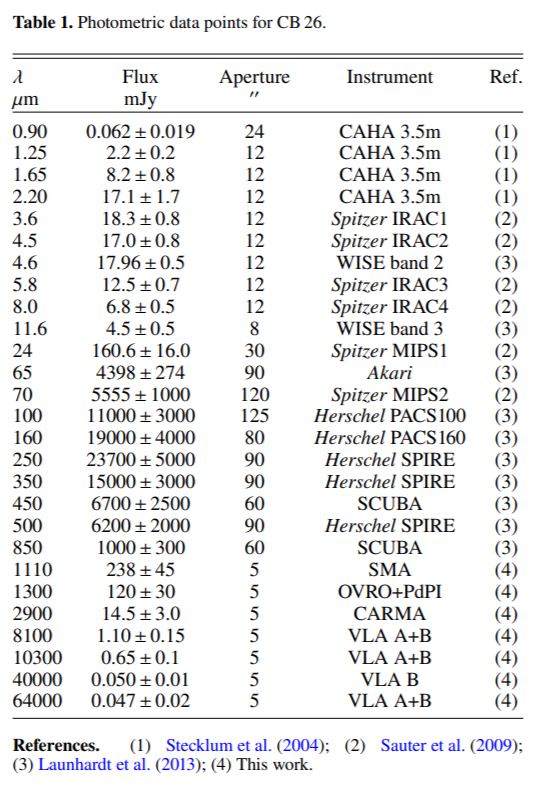

In [61]:
from IPython.display import Image

Image('/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/sed.png')

In [62]:
cb26tbl = Table(rows=data,
                names=['wavelength', 'flux', 'eflux', 'aperture'],
                units=(u.um, u.mJy, u.mJy, u.arcsec)
               )
cb26tbl

<Table length=14>
wavelength    flux          eflux               aperture     
    um        mJy            mJy                 arcsec      
 float64    float64        float64              float64      
---------- --------- -------------------- -------------------
       1.5  3.185245 0.031852450000000004 0.08641975308641975
      1.82  23.57194  0.23571940000000002 0.08641975308641975
      1.87 24.892918  0.24892918000000003 0.08641975308641975
       2.1  78.03873            0.7803873 0.08641975308641975
      2.12  82.88773            0.8288773 0.08641975308641975
       3.0  3.670146           0.03670146 0.08641975308641975
       3.6  51.32531            0.5132531 0.08641975308641975
      4.05 128.25563            1.2825563 0.08641975308641975
       4.1  98.45544   0.9845543999999999 0.08641975308641975
      4.66 13.825704           0.13825704 0.08641975308641975
       4.8 88.085625   0.8808562499999999 0.08641975308641975
       7.7  60.85515            0.6085515 0.08641975308641975
      12.8 88.790344   0.8879034400000001 0.08641975308641975
      25.5 997.54407            9.9754407 0.08641975308641975

We run the Robitaille model grid fitter for each of the geometries in the grid.

We allow for an interstellar extinction ranging from 1 to 30 magnitudes.  The paper gives $A_V\sim13$

In [63]:
fits = {geom:
        fit_a_source(data=cb26tbl['flux'].quantity,
             error=cb26tbl['eflux'].quantity,
             valid=np.ones(len(cb26tbl)), aperture_size=cb26tbl['aperture'].quantity,
             filters=cb26tbl['wavelength'].quantity,
                   av_range=[30,30],
                   distance_range=[8000,8200]*u.pc,
                     geometry=geom,
                     stash_to_mmap=True
                  )
        for geom in geometries}#['spubhmi']} #geometries}
fit_dict = fits

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  s-pbhmi
   Log[d] stepping     :  0.02
   Number of distances :  2

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

Data shape=(90000, 2, 14).  use_memmap=True
   Reading fluxes at 1.5 um


   Reading fluxes at 1.82 um
   Reading fluxes at 1.87 um
   Reading fluxes at 2.1 um
   Reading fluxes at 2.12 um
   Reading fluxes at 3.0 um
   Reading fluxes at 3.6 um
   Reading fluxes at 4.05 um
   Reading fluxes at 4.1 um
   Reading fluxes at 4.66 um
   Reading fluxes at 4.8 um
   Reading fluxes at 7.7 um
   Reading fluxes at 12.8 um
   Reading fluxes at 25.5 um
Moved array with size (90000, 14) to /scratch/local/58736623/tmpg_9_yu4e/s-pbhmi.dat
 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  s-pbsmi
   Log[d] stepping     :  0.02
   Number of distances :  2

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

Data shape=(90000, 2, 14).  use_memmap=True
   Reading fluxes at 1.5 um
   Reading fluxes at 1.82 um
   Reading fluxes at 1.87 um
   Reading flux

`plot_fit` will show the default aperture, 3", as a solid line by default.

It also shows the per-aperture convolved flux as squares with size scaled by aperture size.

$$\chi^2 = \Sigma \frac{(y_i - x_i)^2}{\sigma_i^2}$$

In [64]:
minchi2 = min([np.nanmin(fits[geom].chi2) for geom in fits])
minchi2

<Quantity 205468.61809329>

In the ALMA-IMF-SPICY project, we adopt the following criterion to determine the range of 'compatible' models:

Either
 1) all models with a $\chi^2$ value within $\chi^2 < 3 min(\chi^2)$ if $min(\chi^2) > 3$ or 
 2) all within $\chi^2<9$

In [65]:
chi2limit = minchi2*3 if minchi2 > 3 else 9
deltachi2limit = chi2limit - minchi2

In [66]:
print(f"Delta-chi^2 = {deltachi2limit} for min chi2 = {minchi2}")

Delta-chi^2 = 410937.2361865767 for min chi2 = 205468.61809328833


We make plots for a few geometries:

* `spubsmi`: passive disk, Ulrich envelope, cavity + ambient medium, and inner radius at the sublimation radius
* `sp--s-i`: passive disk only, with inner radius set by the sublimation radius

In [67]:
import plot_fit
imp.reload(plot_fit)
from plot_fit import plot_fit, datafunction

Figure /blue/adamginsbug/adamginsburg/SPICY_ALMAIMF//Location_figures/CB26/None.png doesn't exist


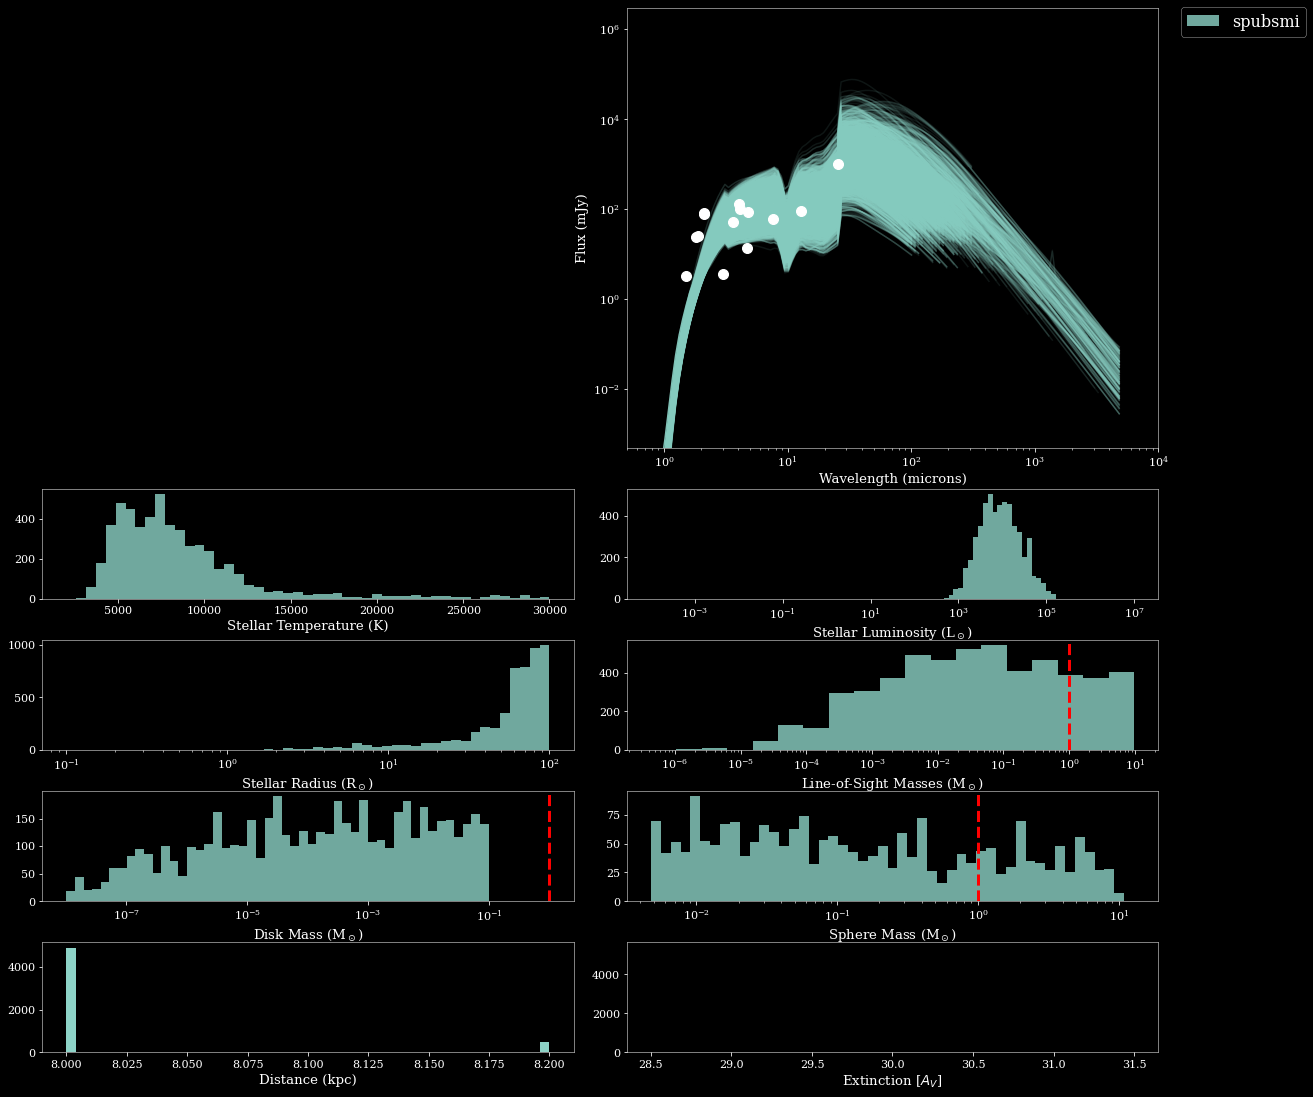

In [68]:
fit = fits['spubsmi']
plot_fit({'spubsmi': fit}, ['spubsmi'], fieldid='CB26', chi2limit=chi2limit, min_chi2=minchi2, show_all_models=True, mass_ul=1);

The disk-only model seems to substantially under-produce flux at long wavelengths, >100 microns

Figure /blue/adamginsbug/adamginsburg/SPICY_ALMAIMF//Location_figures/CB26/None.png doesn't exist


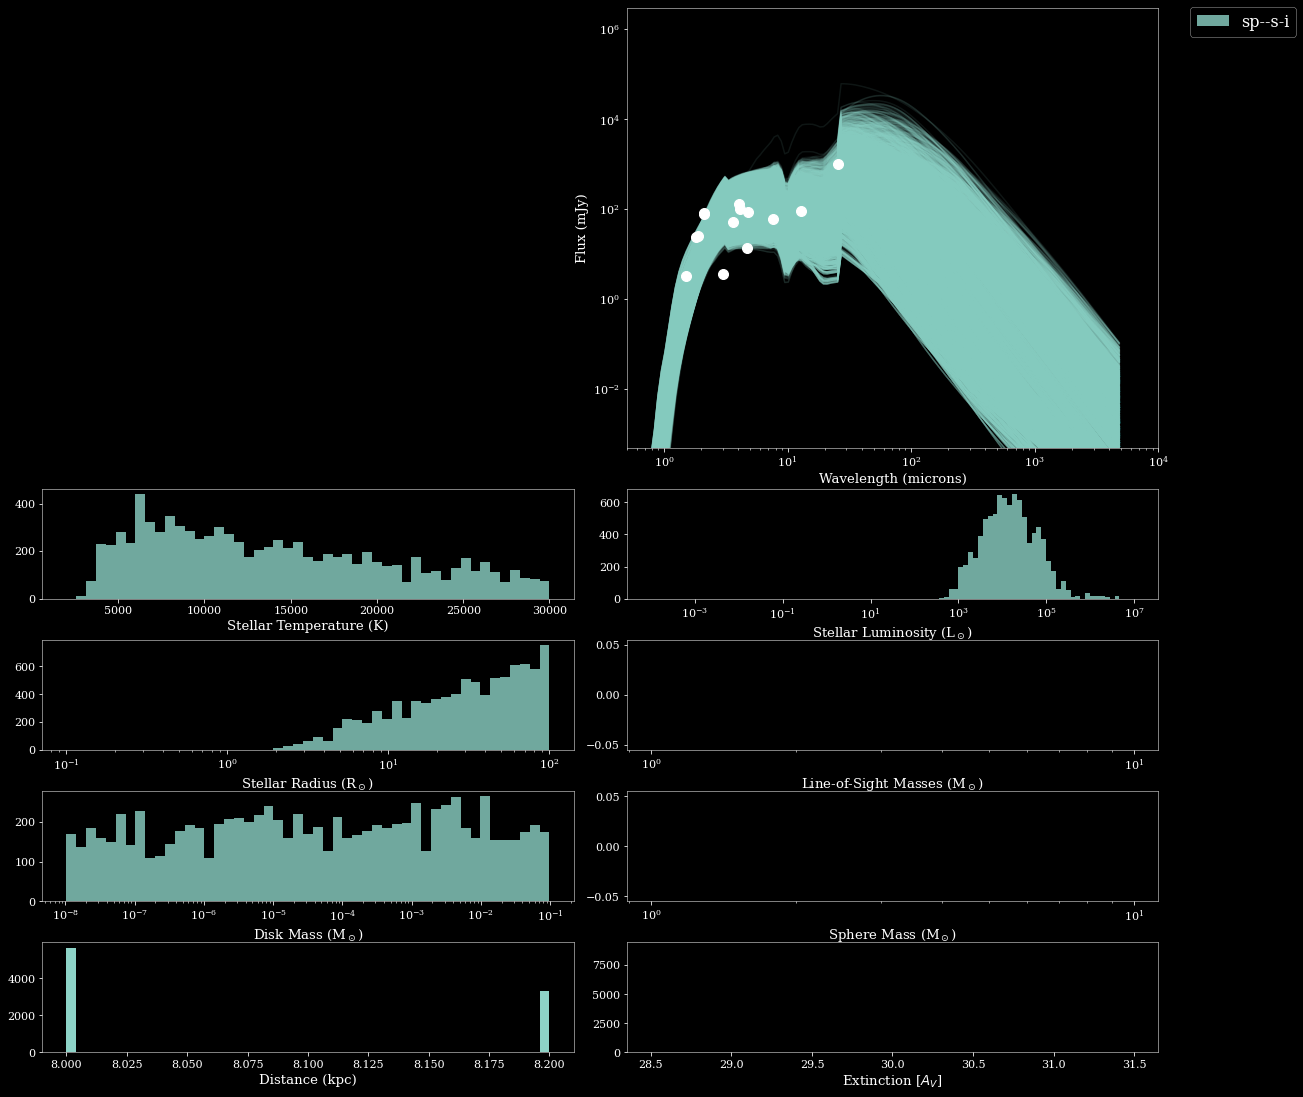

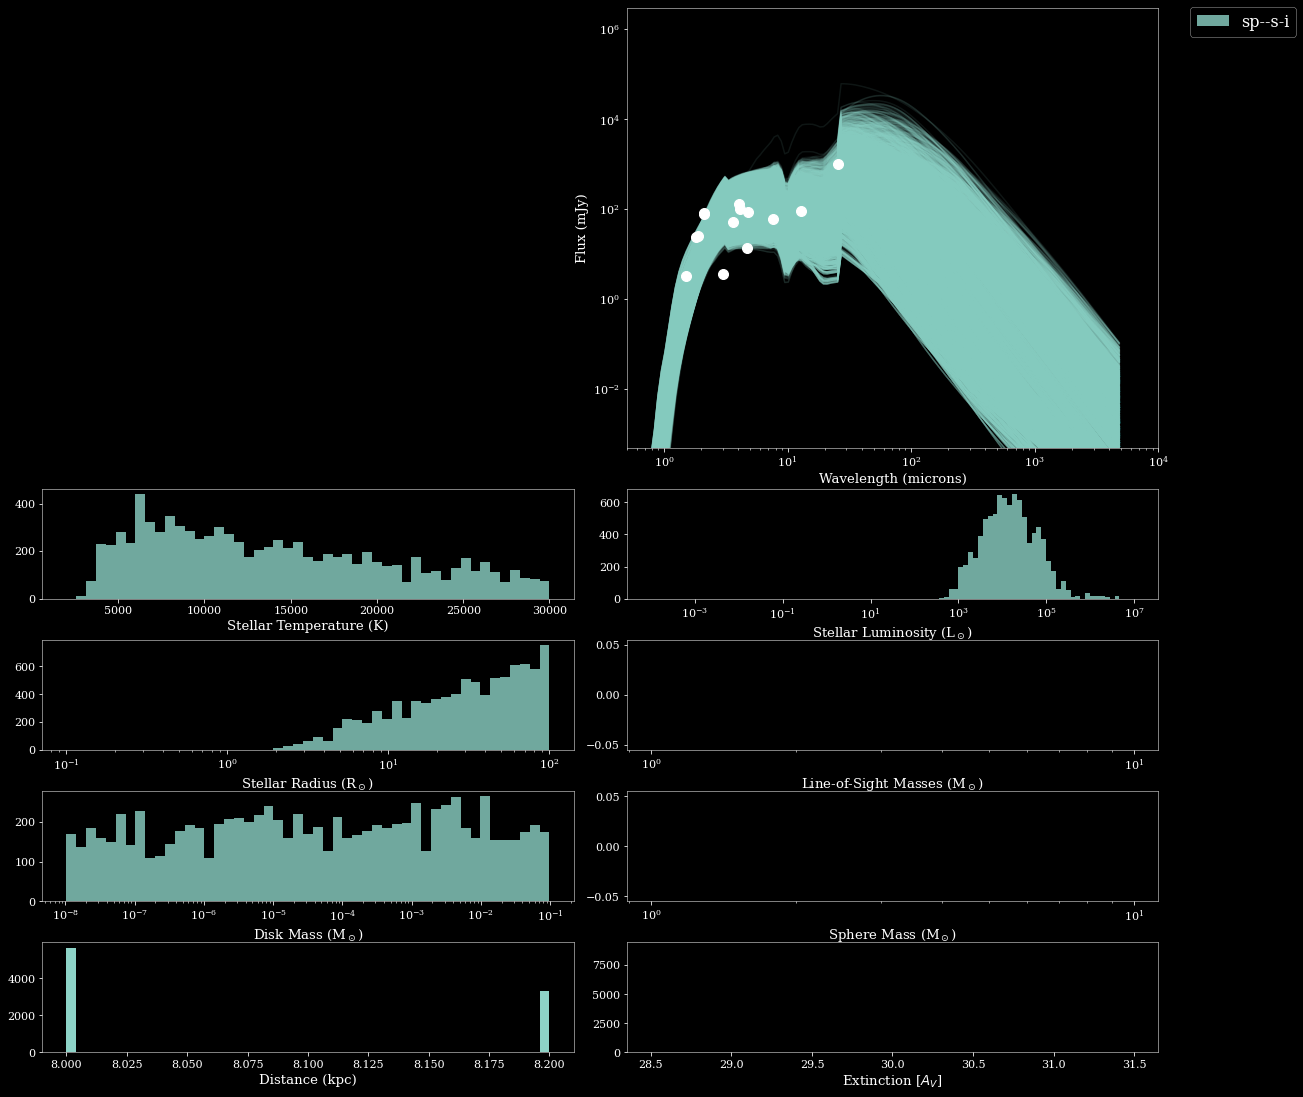

In [69]:
geo = 'sp--s-i'
fit = fits[geo]
plot_fit({geo: fit}, [geo], chi2limit=chi2limit, fieldid='CB26', show_all_models=True, min_chi2=minchi2)

We can compare all geometries that meet the minimum chi^2 limit

In [70]:
okgeo = []
for geom in geometries:
    # we impose an _absolute_ chi^2 limit (the fitter uses a _relative_, delta chi2 limit)
    print(f"{geom}: {np.nanmin(fits[geom].chi2):12.1f}")
    if np.nanmin(fits[geom].chi2) < deltachi2limit+minchi2:
        okgeo.append(geom)

s-pbhmi:     386607.4
s-pbsmi:     409914.9
sp--h-i:     205468.6
s-p-hmi:     433055.5
sp--hmi:     385904.6
sp--s-i:     213963.7
s-p-smi:     449958.2
sp--smi:     330153.6
spubhmi:     349266.7
spubsmi:     323952.3
spu-hmi:     400949.9
spu-smi:     348941.4
s---s-i:     605557.8
s---smi:     538300.5
s-ubhmi:     396670.2
s-ubsmi:     394428.3
s-u-hmi:     470527.5
s-u-smi:     425062.2


In [71]:
import plot_fit
imp.reload(plot_fit)
from plot_fit import plot_fit, datafunction

Figure /blue/adamginsbug/adamginsburg/SPICY_ALMAIMF//Location_figures/None/None.png doesn't exist


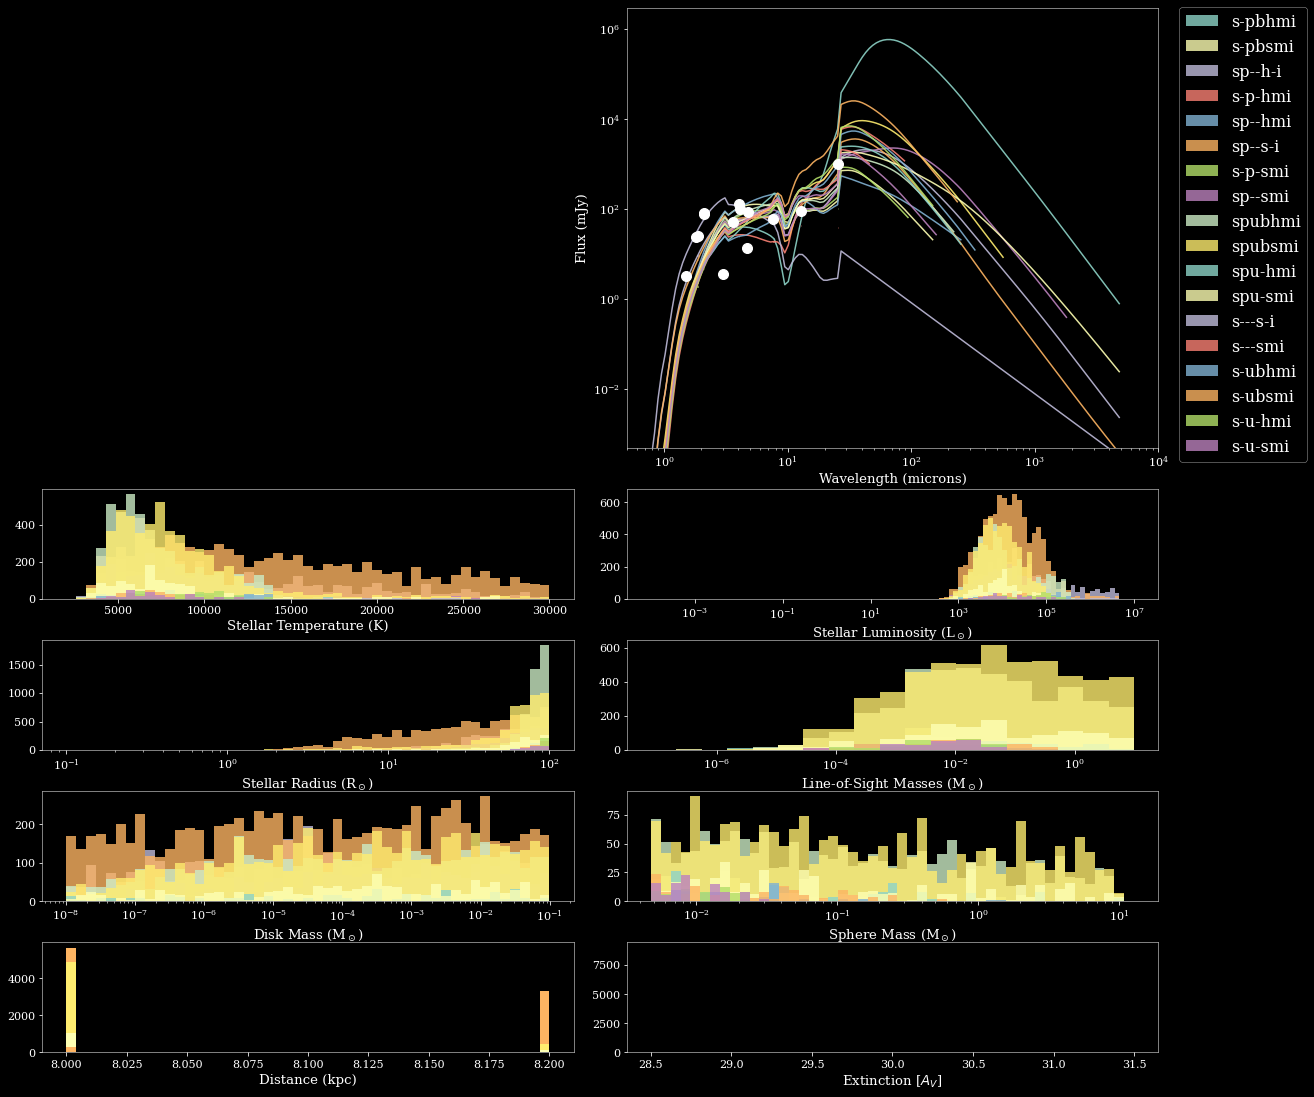

In [72]:
plot_fit(fits, okgeo, chi2limit=chi2limit, min_chi2=minchi2);

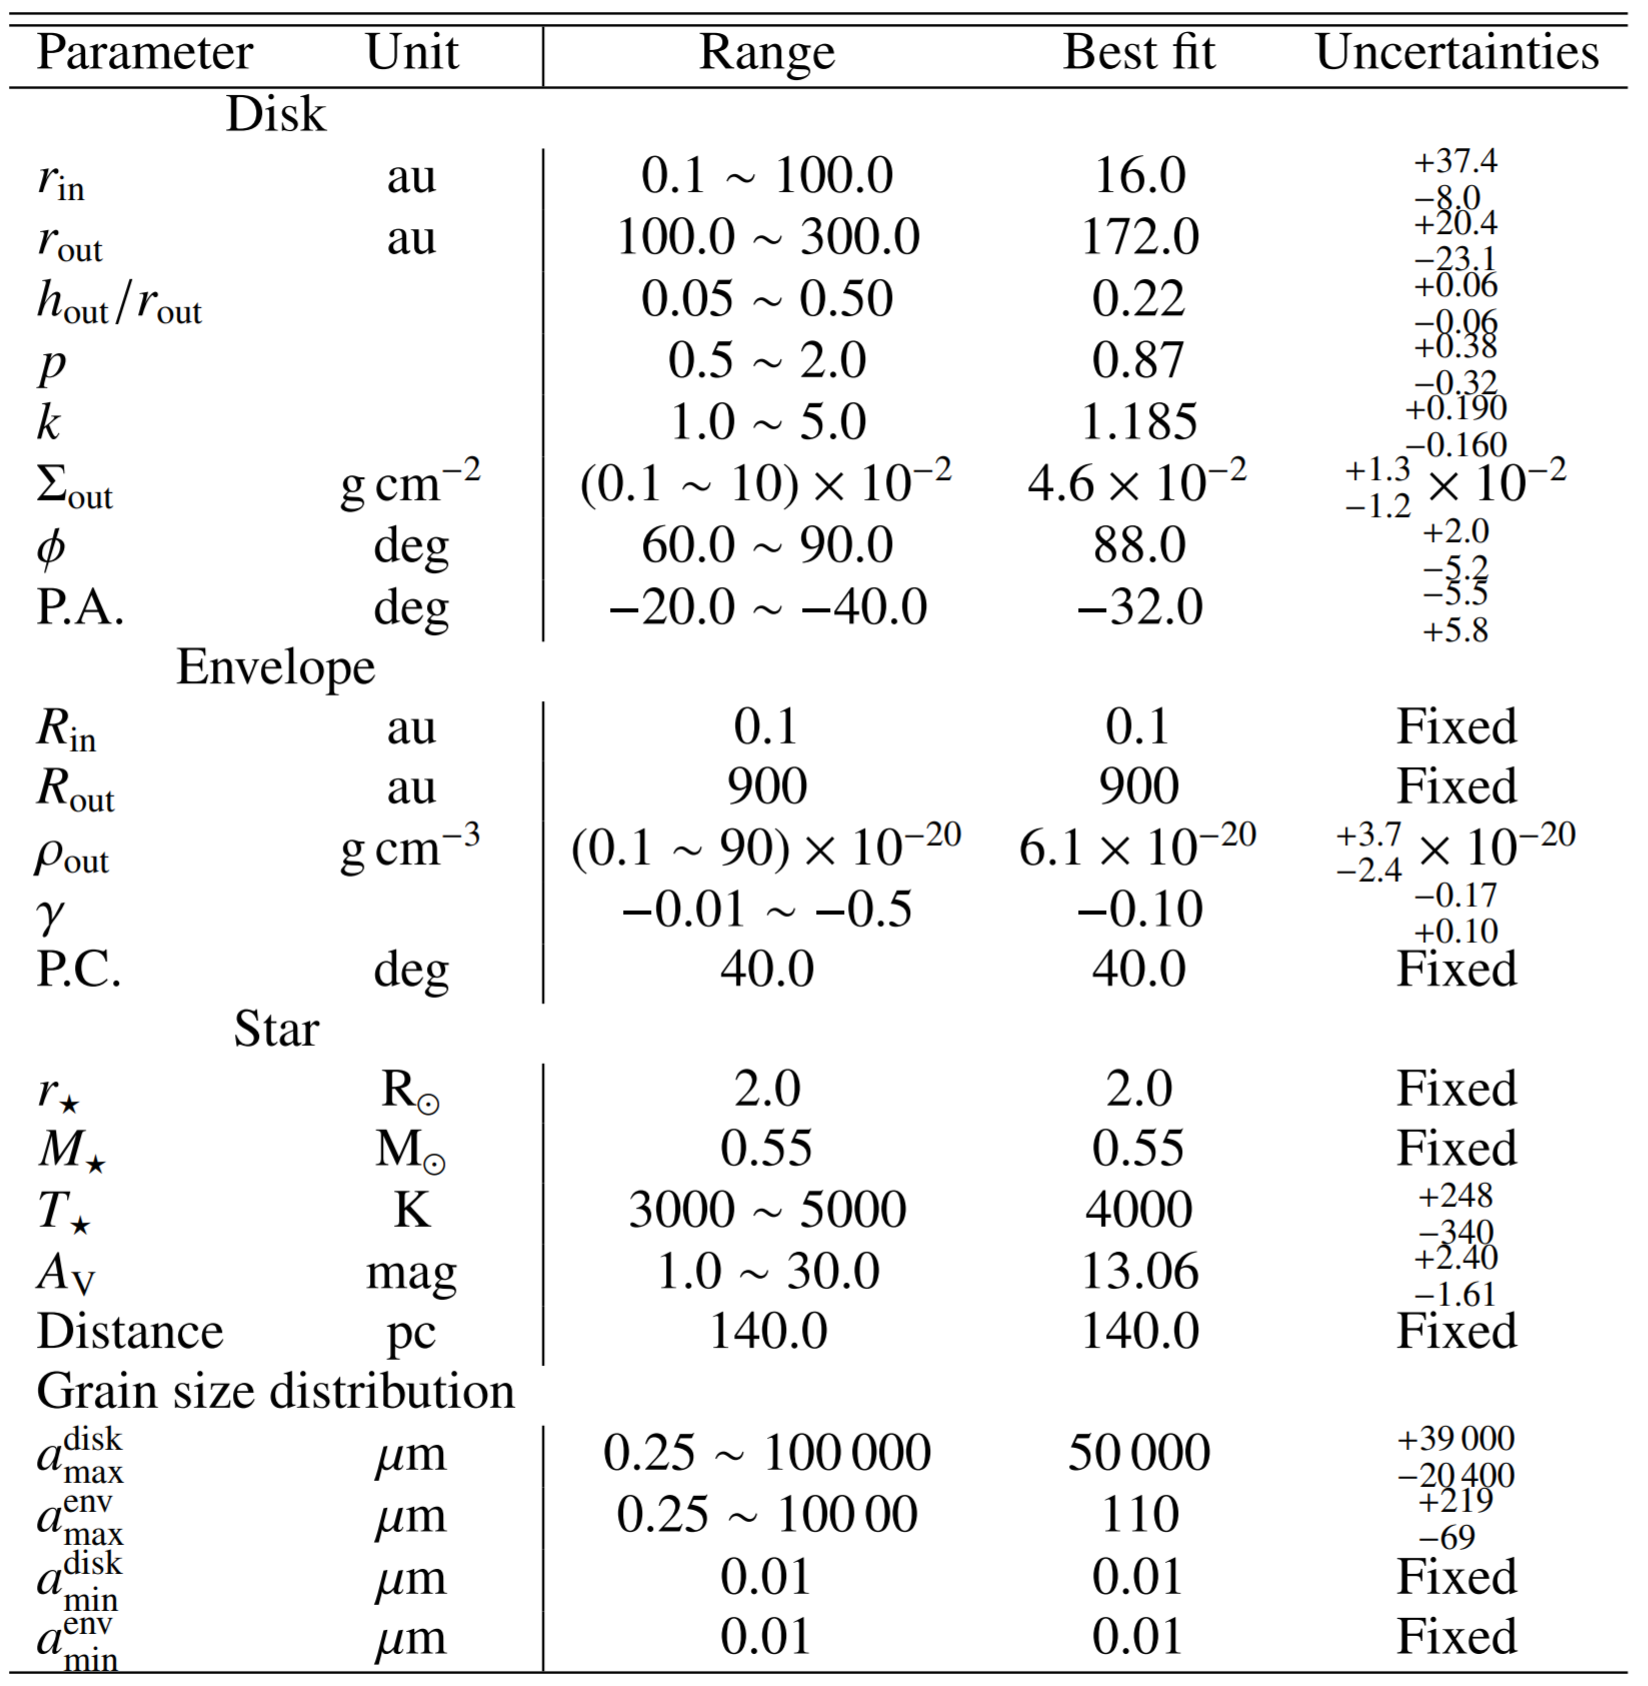

In [73]:
Image('/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/fitpars.png', width=600)

The Robitaille models favor smaller, hotter stars - but similar-ish luminosities.

In [74]:
L_rob = 0.2 *u.L_sun
L_paper = ((4000*u.K)**4 * 4*np.pi*(2*u.R_sun)**2 * constants.sigma_sb).to(u.L_sun)
print(f"Robitaille: {L_rob:0.1f}, Paper: {L_paper:0.1f}, ratio rob/paper: {L_rob/L_paper:0.2f}")

Robitaille: 0.2 solLum, Paper: 0.9 solLum, ratio rob/paper: 0.22


In this plot:

 * White circles are the data
 * Green squares are the model evaluated at that specific aperture & wavelength
 * Green line is the model evaluated at the _default_ aperture

Figure /blue/adamginsbug/adamginsburg/SPICY_ALMAIMF//Location_figures/CB26/None.png doesn't exist


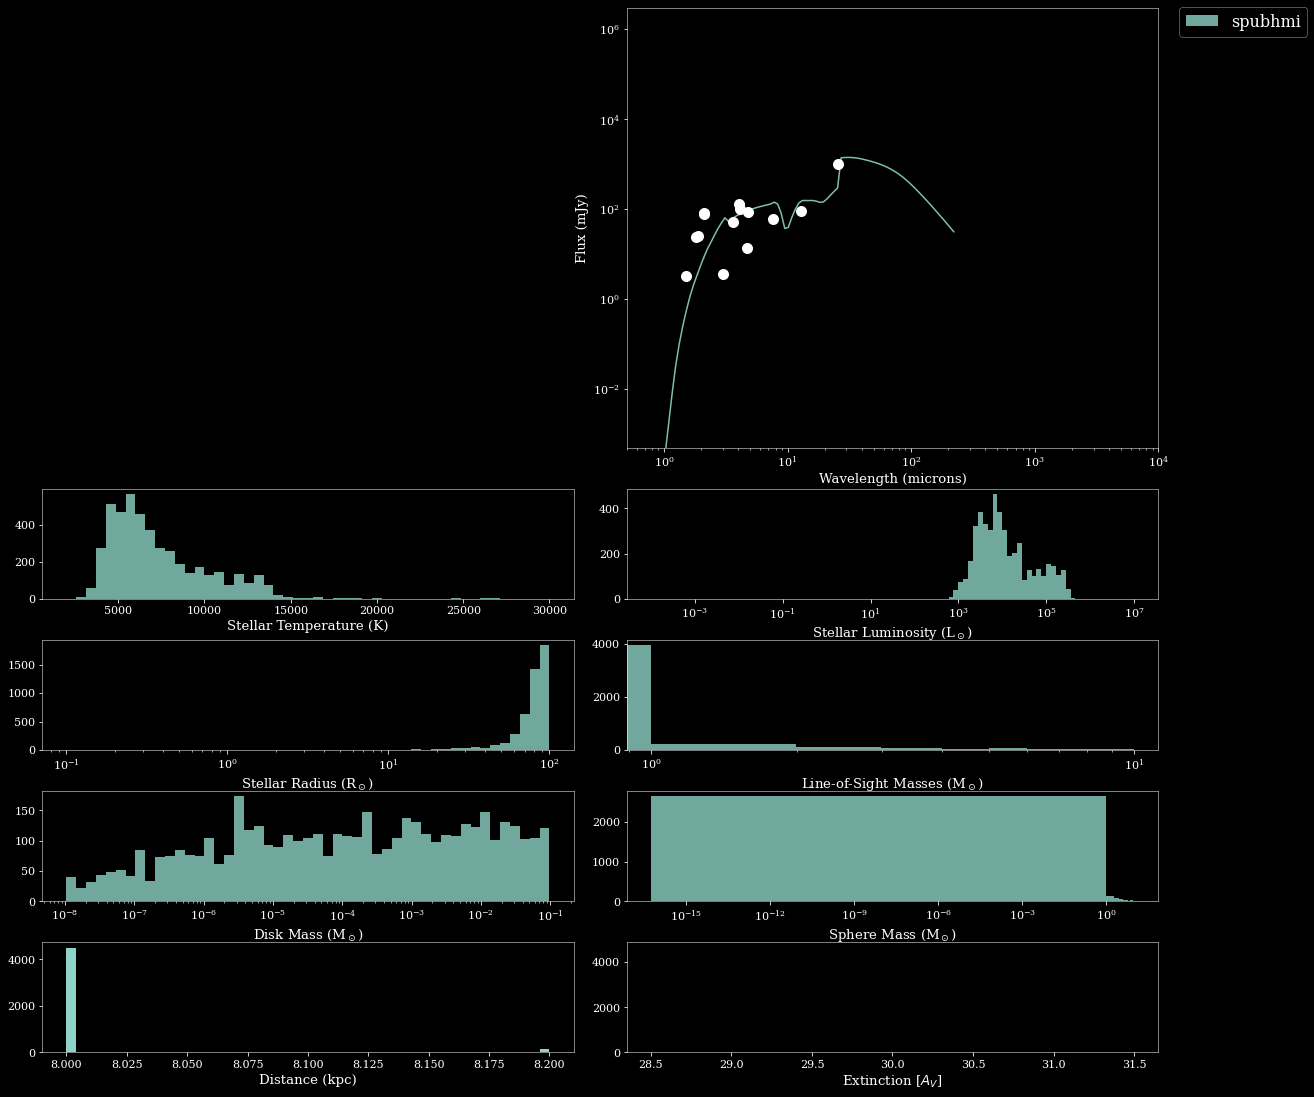

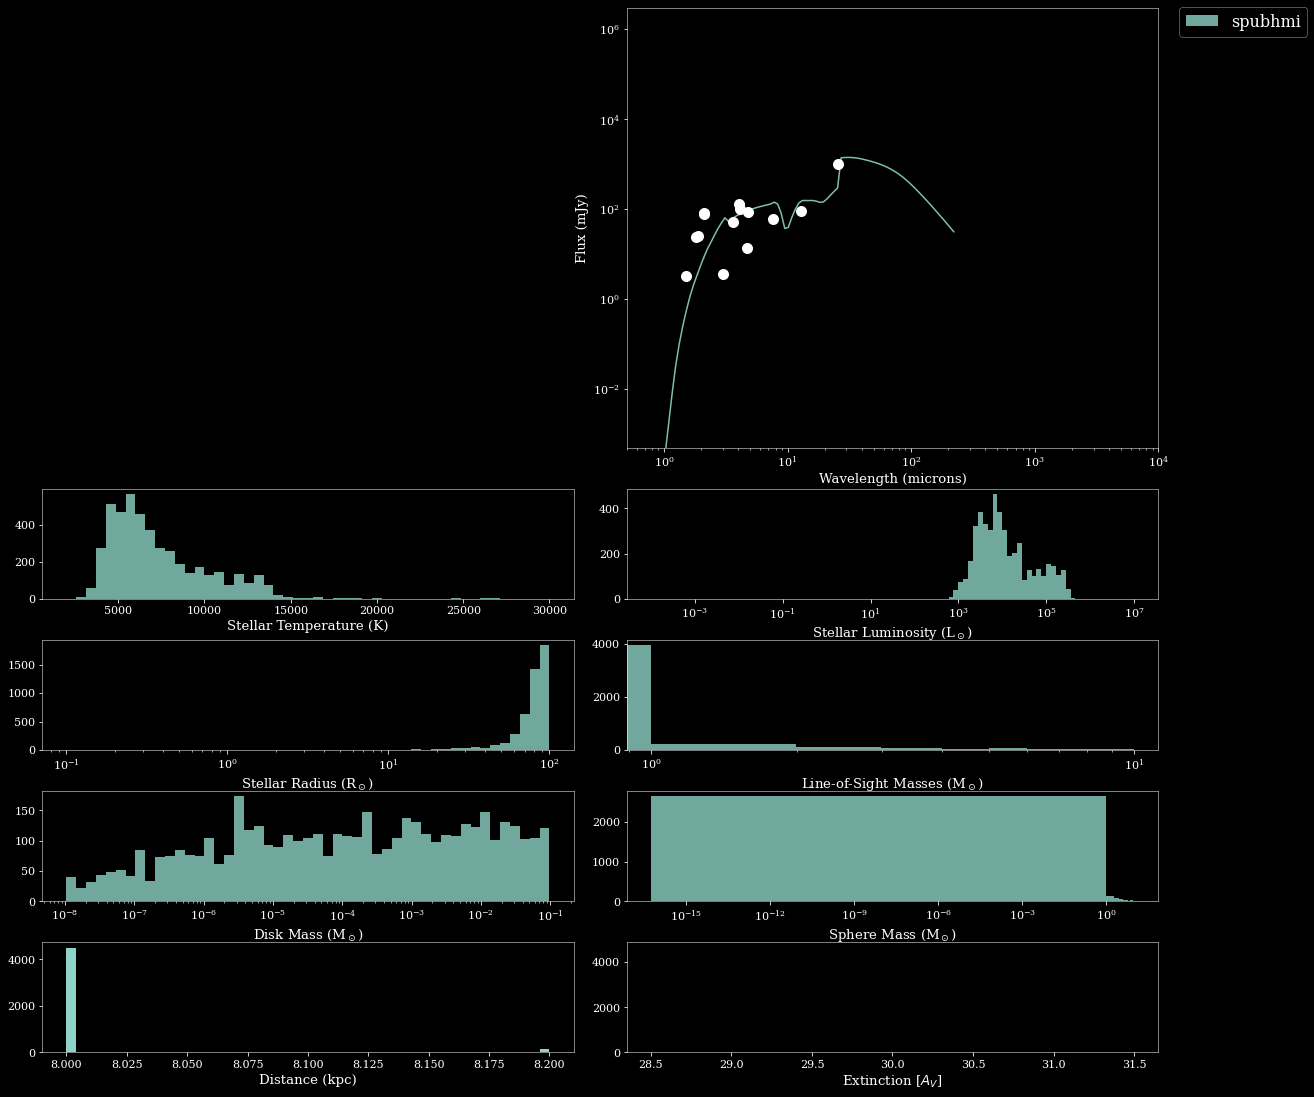

In [75]:
plot_fit(fits, ['spubhmi'], chi2limit=chi2limit, min_chi2=minchi2, fieldid='CB26',)

Figure /blue/adamginsbug/adamginsburg/SPICY_ALMAIMF//Location_figures/CB26/None.png doesn't exist


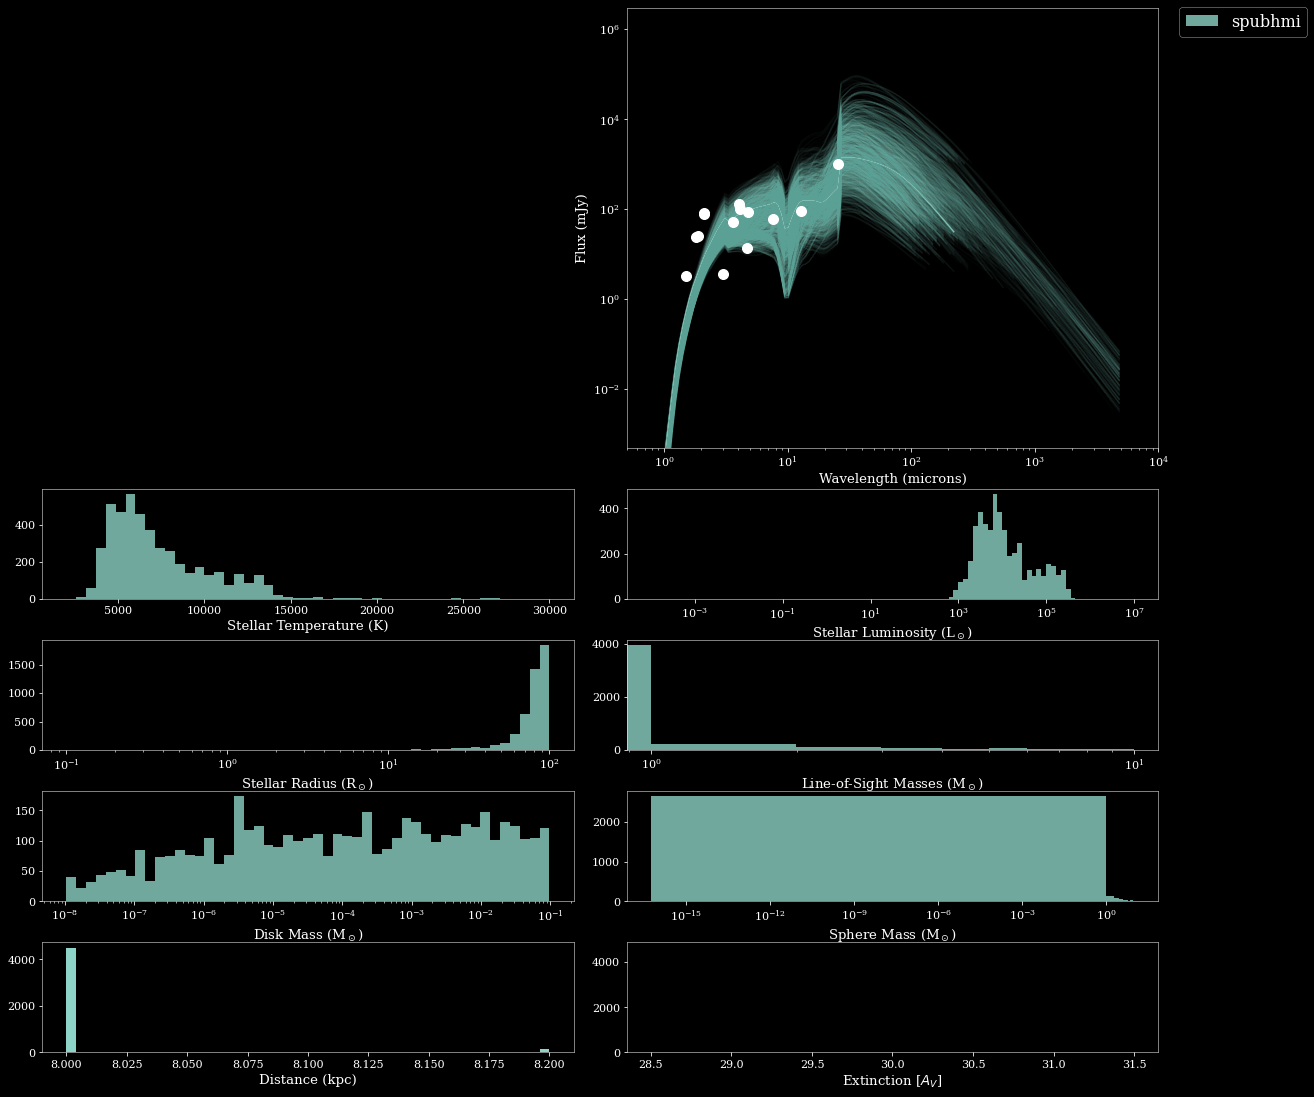

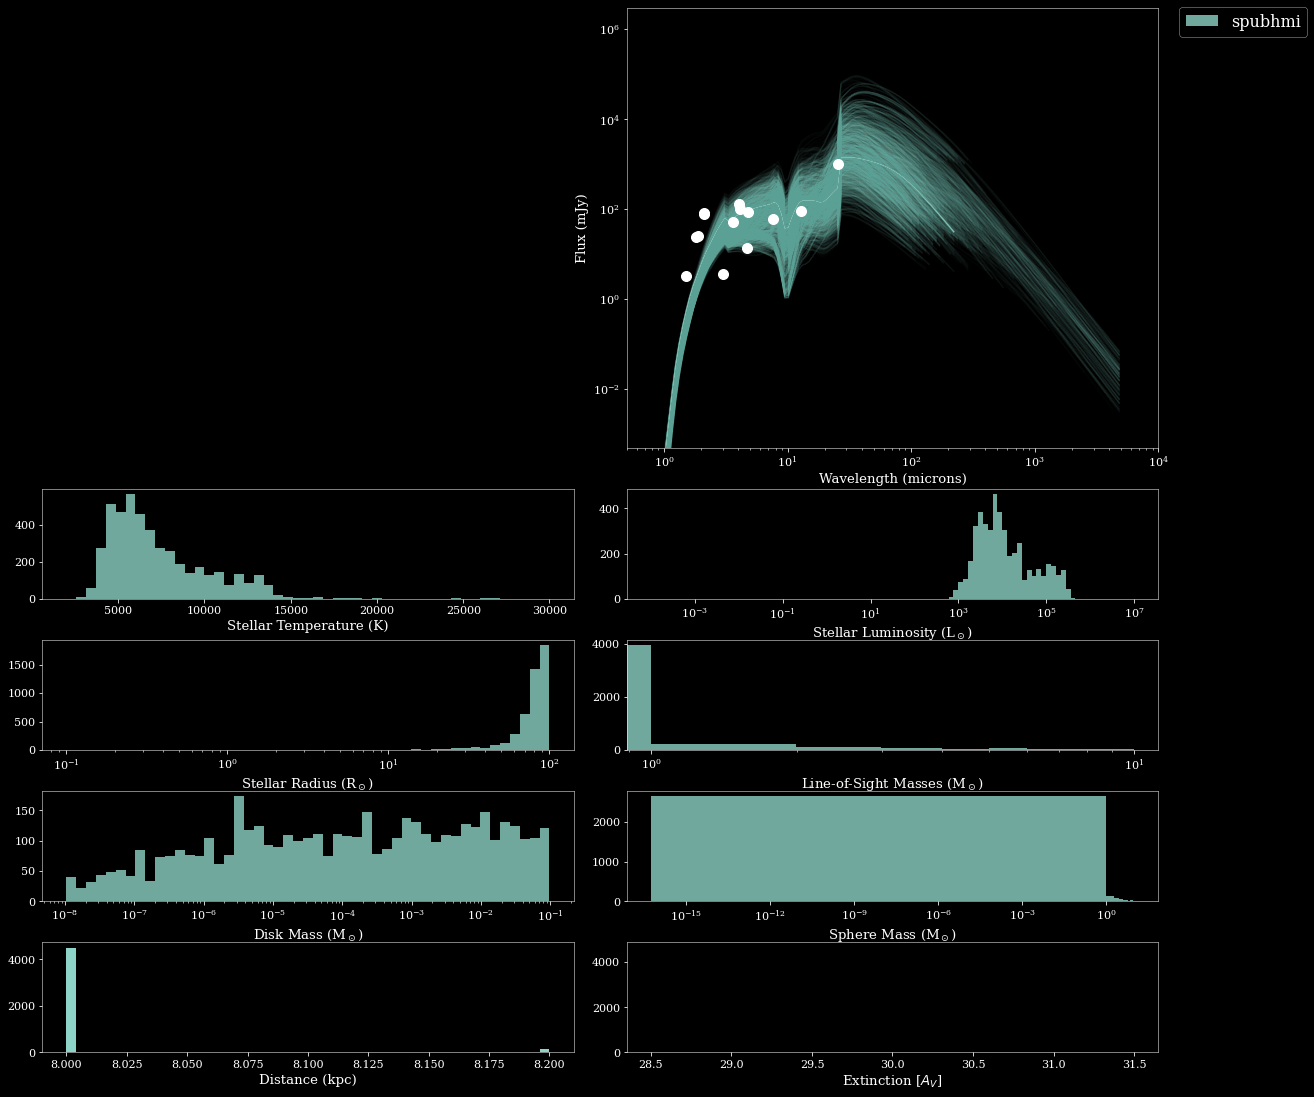

In [76]:
plot_fit(fits, ['spubhmi'], chi2limit=chi2limit, show_all_models=True, min_chi2=minchi2, alpha_allmodels=0.02, fieldid='CB26',)

# Look at A_V and distance vs. chi^2

The above plots tell us that:

1. Most models are "pegged" to the near near/far distance and the min/max A_V.  Models at these extremes are probably not useful (though the distance doesn't matter so much in this case).
2. There seems to be a preferred A_V of ~15 (close to the ~13 from the paper).

In [77]:
geom = 'spubhmi'

pars, data, selection = datafunction(geom, deltachi2limit, fits, min_chi2=minchi2)
fit = fits[geom]
maxchi2 = minchi2 + deltachi2limit
selection = fit.chi2 < maxchi2
len(data)

59

Text(0.5, 0, 'Distance (kpc)')

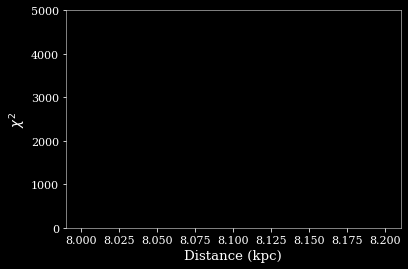

In [78]:
pl.scatter(10**fit.sc, fit.chi2, alpha=0.1)
pl.scatter(10**fit.sc[selection], fit.chi2[selection], alpha=0.2, color='r')
pl.ylim(0,5000)
pl.ylabel("$\chi^2$")
pl.xlabel("Distance (kpc)")

Text(0.5, 0, 'Extinction (A_V)')

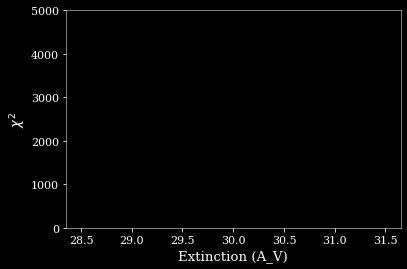

In [79]:
pl.scatter(fit.av, fit.chi2, alpha=0.1)
pl.scatter(fit.av[selection], fit.chi2[selection], alpha=0.2, color='r')
pl.ylim(0,5000)
pl.ylabel("$\chi^2$")
pl.xlabel("Extinction (A_V)")

This is a sanity check to show that the fit is significantly limiting the mass:

[]

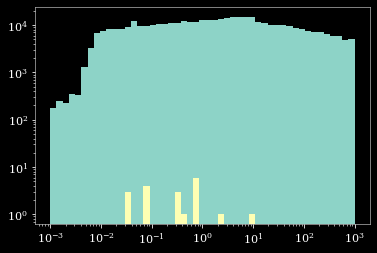

In [80]:
bins = np.logspace(-3,3)
pl.hist(pars['Sphere Masses'][:,9], bins=bins)
pl.hist(data['Sphere Masses'][:,9], bins=bins)

pl.loglog()

[]

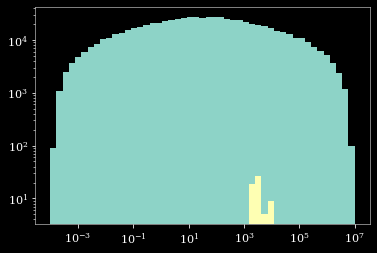

In [81]:
bins = np.logspace(-4,7)
pl.hist(pars['Model Luminosity'][:], bins=bins)
pl.hist(data['Model Luminosity'][:], bins=bins)

pl.loglog()

In [82]:
from sedfitter.sed import SEDCube

In [83]:
# need to check aperture sizes
robitaille_modeldir='/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/'
model_dir = f'{robitaille_modeldir}/{geom}'
sedcube = SEDCube.read(f"{model_dir}/flux.fits",)
sedcube.apertures

<Quantity [1.00000000e+02, 1.62377674e+02, 2.63665090e+02, 4.28133240e+02,
           6.95192796e+02, 1.12883789e+03, 1.83298071e+03, 2.97635144e+03,
           4.83293024e+03, 7.84759970e+03, 1.27427499e+04, 2.06913808e+04,
           3.35981829e+04, 5.45559478e+04, 8.85866790e+04, 1.43844989e+05,
           2.33572147e+05, 3.79269019e+05, 6.15848211e+05, 1.00000000e+06] AU>

In [84]:
sedcube.apertures[5], sedcube.apertures[9]

(<Quantity 1128.83789168 AU>, <Quantity 7847.59970351 AU>)

# Disk and Envelope parameters

In [85]:
diskpars = ['disk.mass', 'disk.rmax', 'disk.beta', 'disk.p', 'disk.h100', 'envelope.rho_0', 'envelope.rc', 'envelope.rmin', 'cavity.power', ]

# Different answer:
spubhmi grid favors a much lower disk mass than the 0.076 Msun from Zhang+

Text(0.5, 0, 'Disk Mass (M$_\\odot$)')

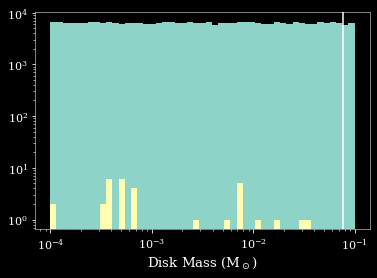

In [86]:
#bins = np.logspace(-3,3)
bins = np.logspace(-4, -1)
pl.hist(pars['disk.mass'], bins=bins)
pl.hist(data['disk.mass'], bins=bins)
pl.axvline(7.6e-2)
pl.loglog()
pl.xlabel("Disk Mass (M$_\odot$)")

## Robitaille grid favors a moderately larger envelope mass (at least for spubhmi)

S4.4 of the paper says M_env = 0.033 Msun within 900 AU and M_env = 0.22 Msun within 10^4 AU

Text(0.5, 1.0, 'Aperture 9=$10^4$ AU')

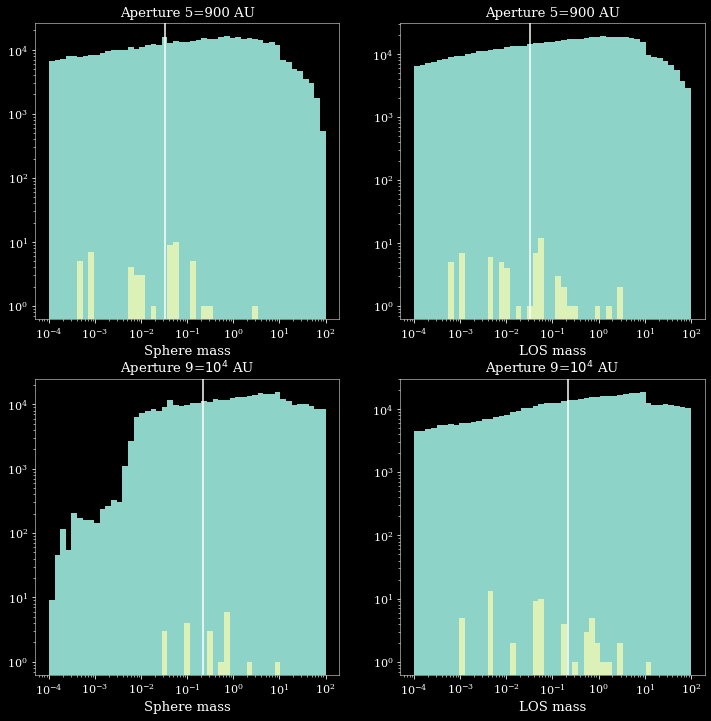

In [87]:
# mass comparisons
pl.figure(figsize=(12,12))
pl.subplot(2,2,1)
bins = np.logspace(-4, 2)
pl.hist(pars['Sphere Masses'][:,5], bins=bins)
pl.hist(data['Sphere Masses'][:,5], bins=bins, alpha=0.7)
pl.axvline(3.3e-2)
pl.loglog()
pl.xlabel("Sphere mass")
pl.title("Aperture 5=900 AU")

pl.subplot(2,2,2)
pl.hist(pars['Line-of-Sight Masses'][:,5], bins=bins)
pl.hist(data['Line-of-Sight Masses'][:,5], bins=bins, alpha=0.7)
pl.axvline(3.3e-2)
pl.loglog()
pl.xlabel("LOS mass")
pl.title("Aperture 5=900 AU")

pl.subplot(2,2,3)
pl.hist(pars['Sphere Masses'][:,9], bins=bins)
pl.hist(data['Sphere Masses'][:,9], bins=bins, alpha=0.7)
pl.axvline(0.22)
pl.loglog()
pl.xlabel("Sphere mass")
pl.title("Aperture 9=$10^4$ AU")

pl.subplot(2,2,4)
pl.hist(pars['Line-of-Sight Masses'][:,9], bins=bins)
pl.hist(data['Line-of-Sight Masses'][:,9], bins=bins, alpha=0.7)
pl.axvline(0.22)
pl.loglog()
pl.xlabel("LOS mass")
pl.title("Aperture 9=$10^4$ AU")

Text(0.5, 0, 'Disk max radius')

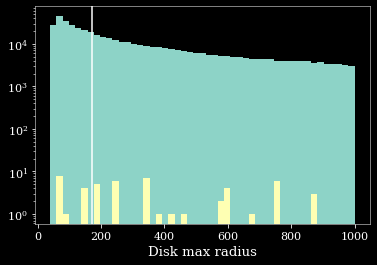

In [88]:
#bins = np.logspace(-3,3)
bins = np.linspace(40, 1000)
pl.hist(pars['disk.rmax'], bins=bins)
pl.hist(data['disk.rmax'], bins=bins)
pl.axvline(172)
pl.semilogy()
pl.xlabel("Disk max radius")

Text(0.5, 0, 'Disk power-law index $p$')

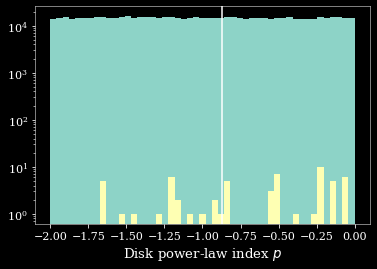

In [89]:
#bins = np.logspace(-3,3)
bins = np.linspace(-2,0)
pl.hist(pars['disk.p'], bins=bins)
pl.hist(data['disk.p'], bins=bins)
pl.axvline(-0.87)
pl.semilogy()
pl.xlabel("Disk power-law index $p$")

Text(0.5, 0, 'Disk inclination')

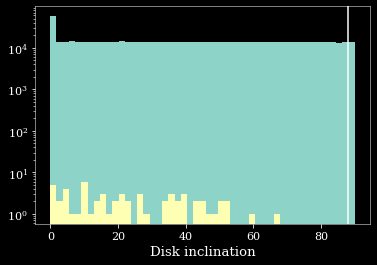

In [90]:
#bins = np.logspace(-3,3)
bins = np.linspace(0,90)
pl.hist(pars['inclination'], bins=bins)
pl.hist(data['inclination'], bins=bins)
pl.axvline(88) #Zhang number?
pl.semilogy()
pl.xlabel("Disk inclination")

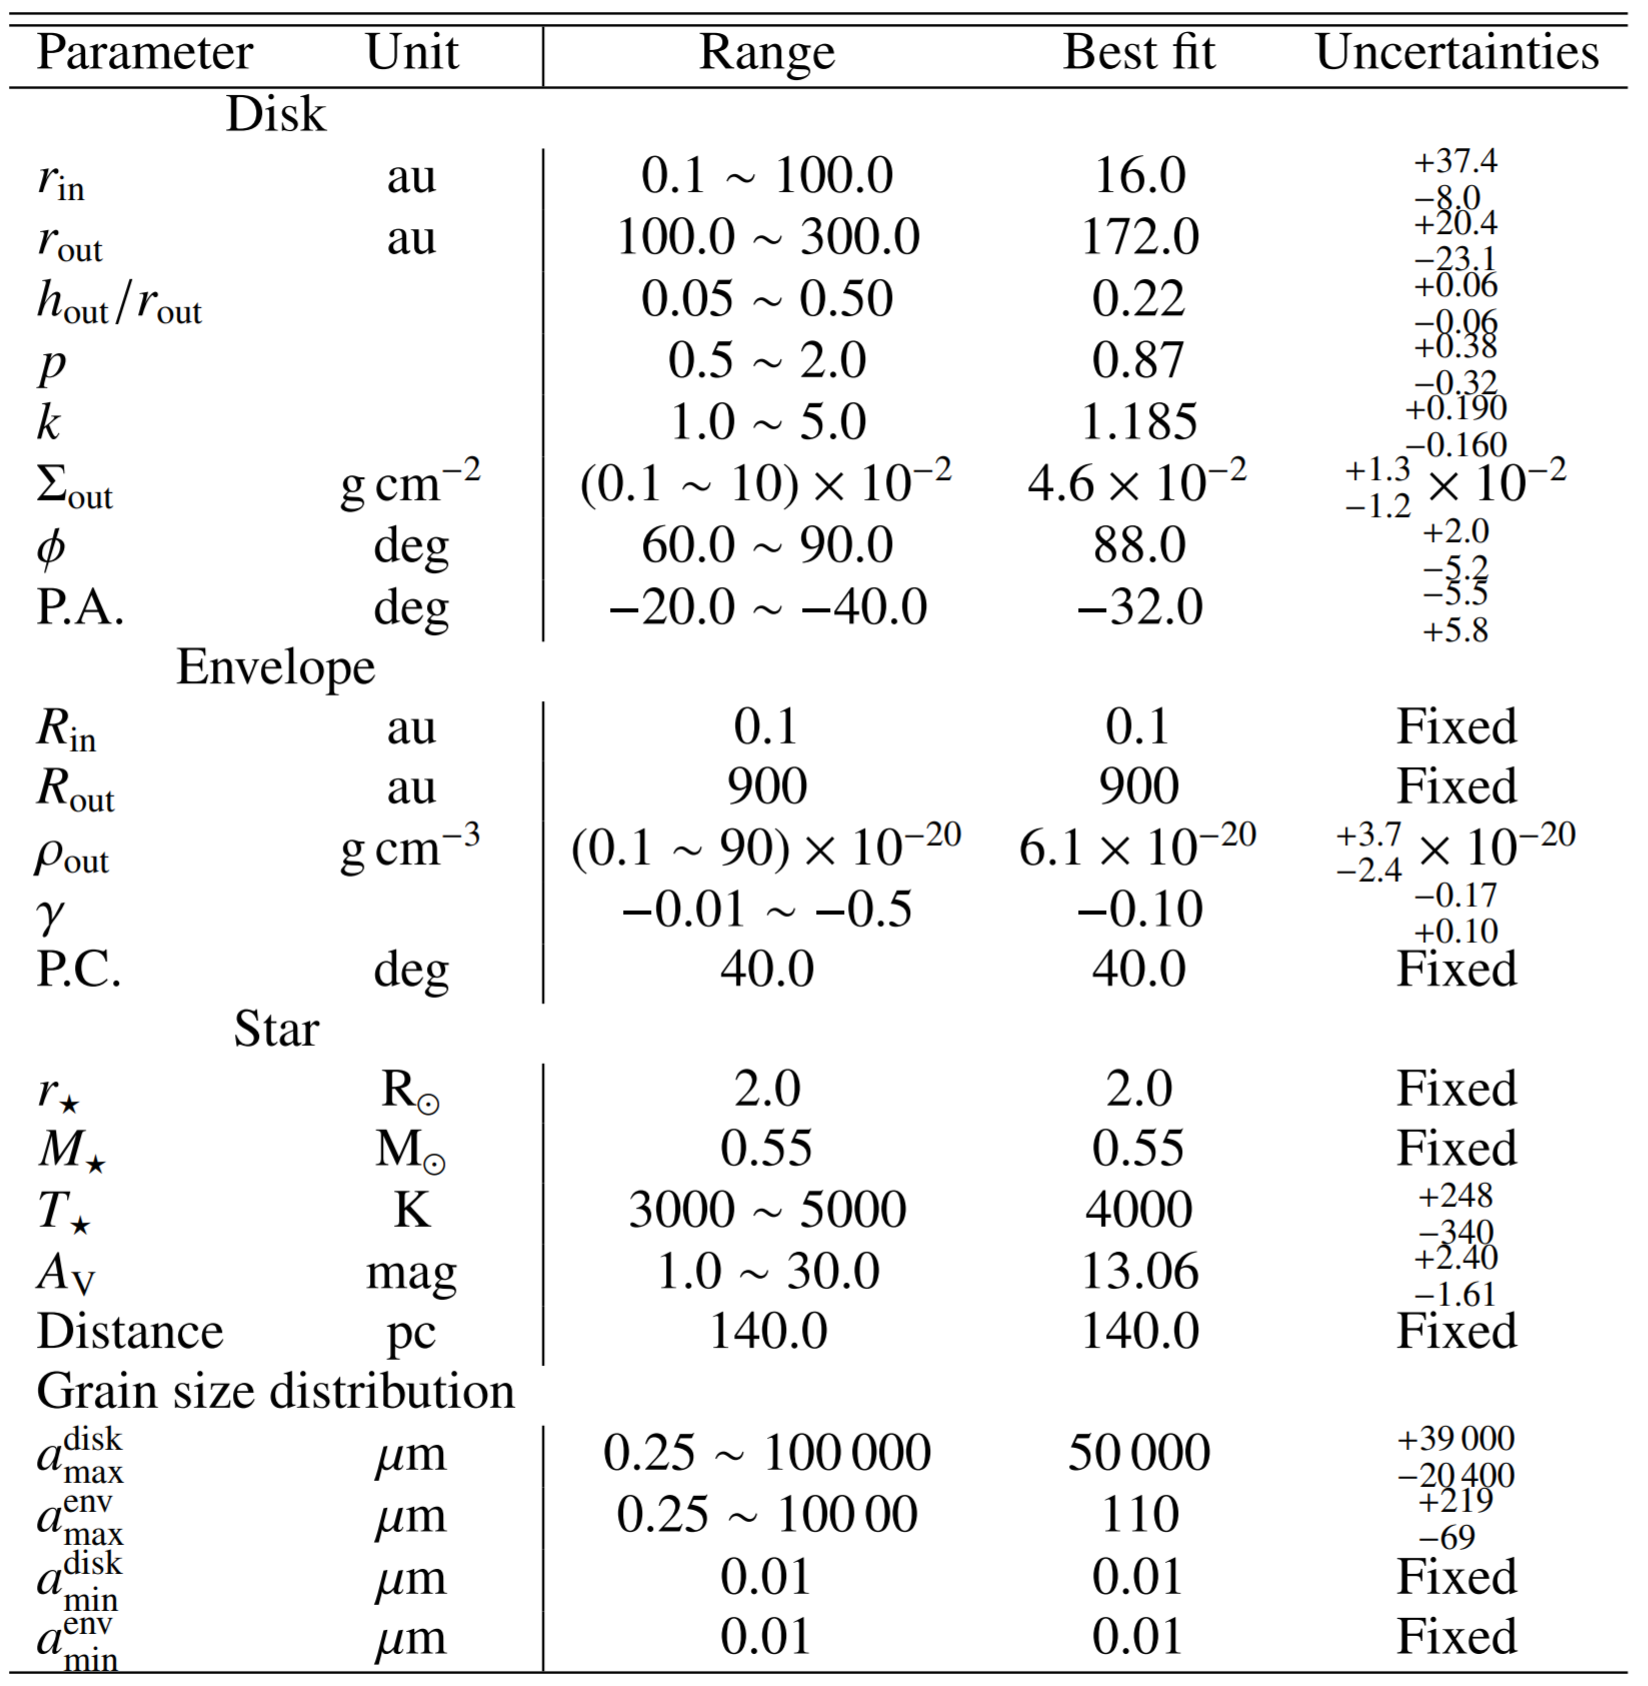

In [91]:
Image('/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/fitpars.png', width=600)

# Compare to Optically Thin dust model

In [92]:
from dust_emissivity import dust

In [93]:
flux_1mm = 120*u.mJy
distance = 140*u.pc
optthinmass = dust.massofsnu(nu=(1110.0*u.um).to(u.GHz, u.spectral()),
                             snu=flux_1mm, distance=distance, temperature=20*u.K)
optthinmass

<Quantity 0.03121736 solMass>

In [94]:
data['disk.mass', 'Line-of-Sight Masses', 'Sphere Masses']

<Table length=59>
disk.mass ...        Sphere Masses        
 float64  ...         float64[20]         
--------- ... ----------------------------
0.0003849 ...   0.007490839265498773 .. --
0.0003849 ...   0.007490839265498773 .. --
3.223e-05 ...  6.269854198647293e-05 .. --
0.0005347 ...   0.010463803288248202 .. --
0.0005347 ...   0.010463803288248202 .. --
0.0003849 ...   0.007490839265498773 .. --
0.0005347 ...   0.010463803288248202 .. --
0.0003849 ...   0.007490839265498773 .. --
0.0005347 ...   0.010463803288248202 .. --
0.0003849 ...   0.007490839265498773 .. --
      ... ...                          ...
5.099e-06 ...  8.552899630316751e-05 .. --
 0.007345 ...   0.008323233225503041 .. --
3.111e-06 ... 0.00010648590910880829 .. --
4.612e-06 ... 0.00010246406910733527 .. --
5.099e-06 ...  8.552899630316751e-05 .. --
5.099e-06 ...  8.552899630316751e-05 .. --
 0.007345 ...   0.008323233225503041 .. --
5.099e-06 ...  8.552899630316751e-05 .. --
  0.01645 ...     1.6590758825787093 .. --
 0.002871 ...    0.03155745940445313 .. --

## Plot: show the mass as a function of radius

We're using a 5" aperture in this case for the long-wavelength, mass-estimating scale

In [95]:
from itertools import cycle
from matplotlib import pyplot as plt

Text(0, 0.5, 'Mass (M$_\\odot$)')

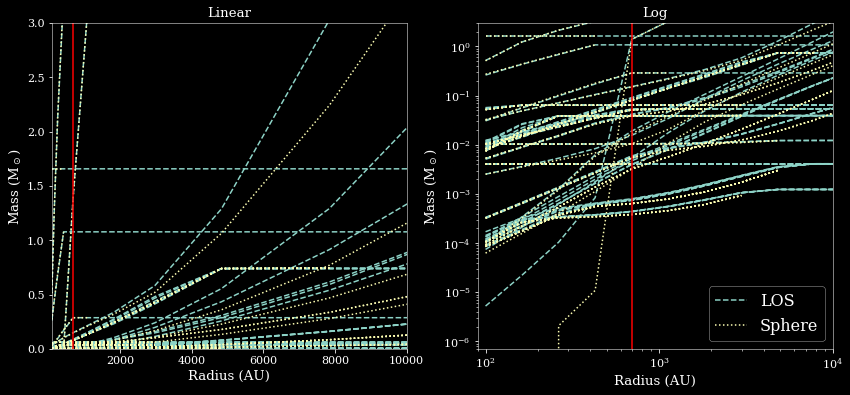

In [96]:
aperture_1mm = 5*u.arcsec

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])

pl.figure(figsize=(14,6))
pl.subplot(1,2,1)
lines1 = pl.plot(sedcube.apertures, np.array(data['Line-of-Sight Masses']).T, label='LOS', linestyle='--', color=next(colors))
lines2 = pl.plot(sedcube.apertures, np.array(data['Sphere Masses']).T, label='Sphere', linestyle=':', color=next(colors))
pl.axvline((distance * aperture_1mm).to(u.au, u.dimensionless_angles()).value, color='r')
pl.axis([90,1e4,0,3])
pl.title("Linear")
pl.xlabel("Radius (AU)")
pl.ylabel("Mass (M$_\odot$)")
pl.subplot(1,2,2)
pl.plot(sedcube.apertures, np.array(data['Line-of-Sight Masses']).T, label='LOS', linestyle='--', color=lines1[0].get_color())
pl.plot(sedcube.apertures, np.array(data['Sphere Masses']).T, label='Sphere', linestyle=':', color=lines2[0].get_color())
pl.axvline((distance * aperture_1mm).to(u.au, u.dimensionless_angles()).value, color='r')
pl.loglog()
pl.legend(handles=[lines1[0], lines2[0]], loc='lower right')
pl.axis([90,1e4,0,3])
pl.title("Log")
pl.xlabel("Radius (AU)")
pl.ylabel("Mass (M$_\odot$)")

# 2D Flux Plots

The SEDs are calculated in a two-dimensional grid of wavelength and aperture.   Let's see where our measurements fall and how they compare.

In [97]:
obs_apertures = (cb26tbl['aperture'] * distance).to(u.au, u.dimensionless_angles())
obs_apertures                                  

<Quantity [12.09876543, 12.09876543, 12.09876543, 12.09876543, 12.09876543,
           12.09876543, 12.09876543, 12.09876543, 12.09876543, 12.09876543,
           12.09876543, 12.09876543, 12.09876543, 12.09876543] AU>

In [98]:
obs_apnums = np.interp(obs_apertures, sedcube.apertures, np.arange(len(sedcube.apertures)))
obs_apnums

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [99]:
obs_wavs = cb26tbl['wavelength'].to(u.um)
obs_wlnums = np.interp(obs_wavs, sedcube.wav[::-1], np.arange(len(sedcube.wav))[::-1])
obs_wlnums, obs_wavs

(array([123.13591239, 120.18989524, 119.77759437, 118.00402307,
        117.86335942, 112.57579385, 109.79439149, 107.99401391,
        107.81188292, 105.85952564, 105.41227375,  98.20662751,
         90.46352732,  79.95219456]),
 <Quantity [ 1.5 ,  1.82,  1.87,  2.1 ,  2.12,  3.  ,  3.6 ,  4.05,  4.1 ,
             4.66,  4.8 ,  7.7 , 12.8 , 25.5 ] um>)

In [100]:
from astropy.visualization import simple_norm

In [101]:
sedcube.apertures.min()

<Quantity 100. AU>

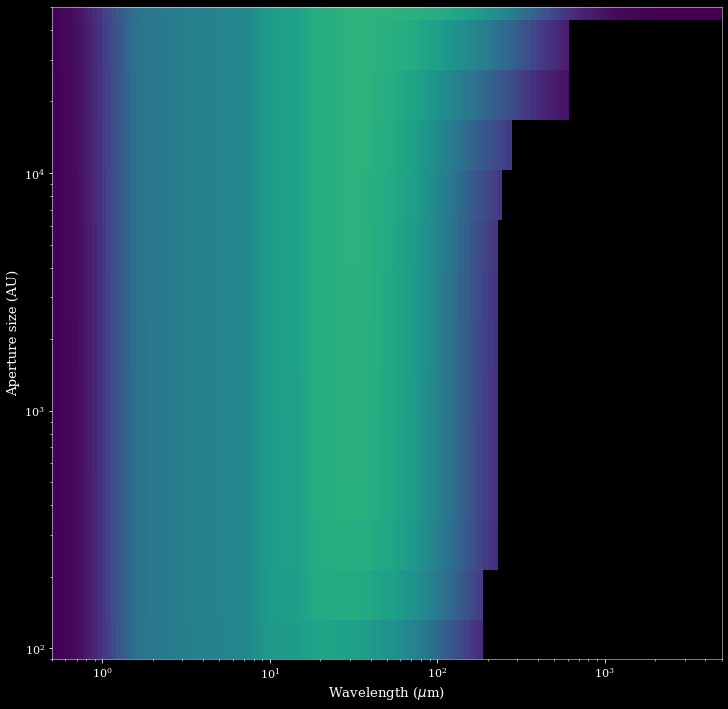

In [102]:
pl.figure(figsize=(12,12))
pl.rcParams['font.size'] = 16
ax = pl.gca()
mdl = sedcube.get_sed(data['MODEL_NAME'][0]).flux.value
norm = simple_norm(mdl, stretch='log')
ax.pcolormesh(sedcube.wav.value, sedcube.apertures.value, mdl[:,:], norm=norm)# extent=[x.value for x in [sedcube.wav.min(), sedcube.wav.max(), sedcube.apertures.min(), sedcube.apertures.max()]],
              #aspect=1./10,
              #origin='lower')
#ax.scatter(len(sedcube.wav) - obs_wlnums, obs_apnums, c=cb26tbl['flux'].to(u.mJy), norm=norm, edgecolors='w', linewidths=0.15)
_=ax.scatter(obs_wavs.value, obs_apertures.value, c=cb26tbl['flux'].to(u.mJy).value, norm=norm, edgecolors='w', linewidths=0.5)
#_=ax.axis([0.5*u.um, 1*u.cm, 90*u.au, 1e5*u.au])
ax.loglog()
_=ax.axis([0.5, 0.5e4, 90, 5e4])
_=ax.set_xlabel("Wavelength ($\mu$m)")
_=ax.set_ylabel("Aperture size (AU)")
#ax.set_xticklabels([f"{x:0.1f}" for x in np.interp(ax.get_xticks(), np.arange(len(sedcube.wav)), sedcube.wav)][::-1])
#_=ax.set_yticklabels([f"{x:0.1f}" for x in np.interp(ax.get_yticks(), np.arange(len(sedcube.apertures)), sedcube.apertures)])

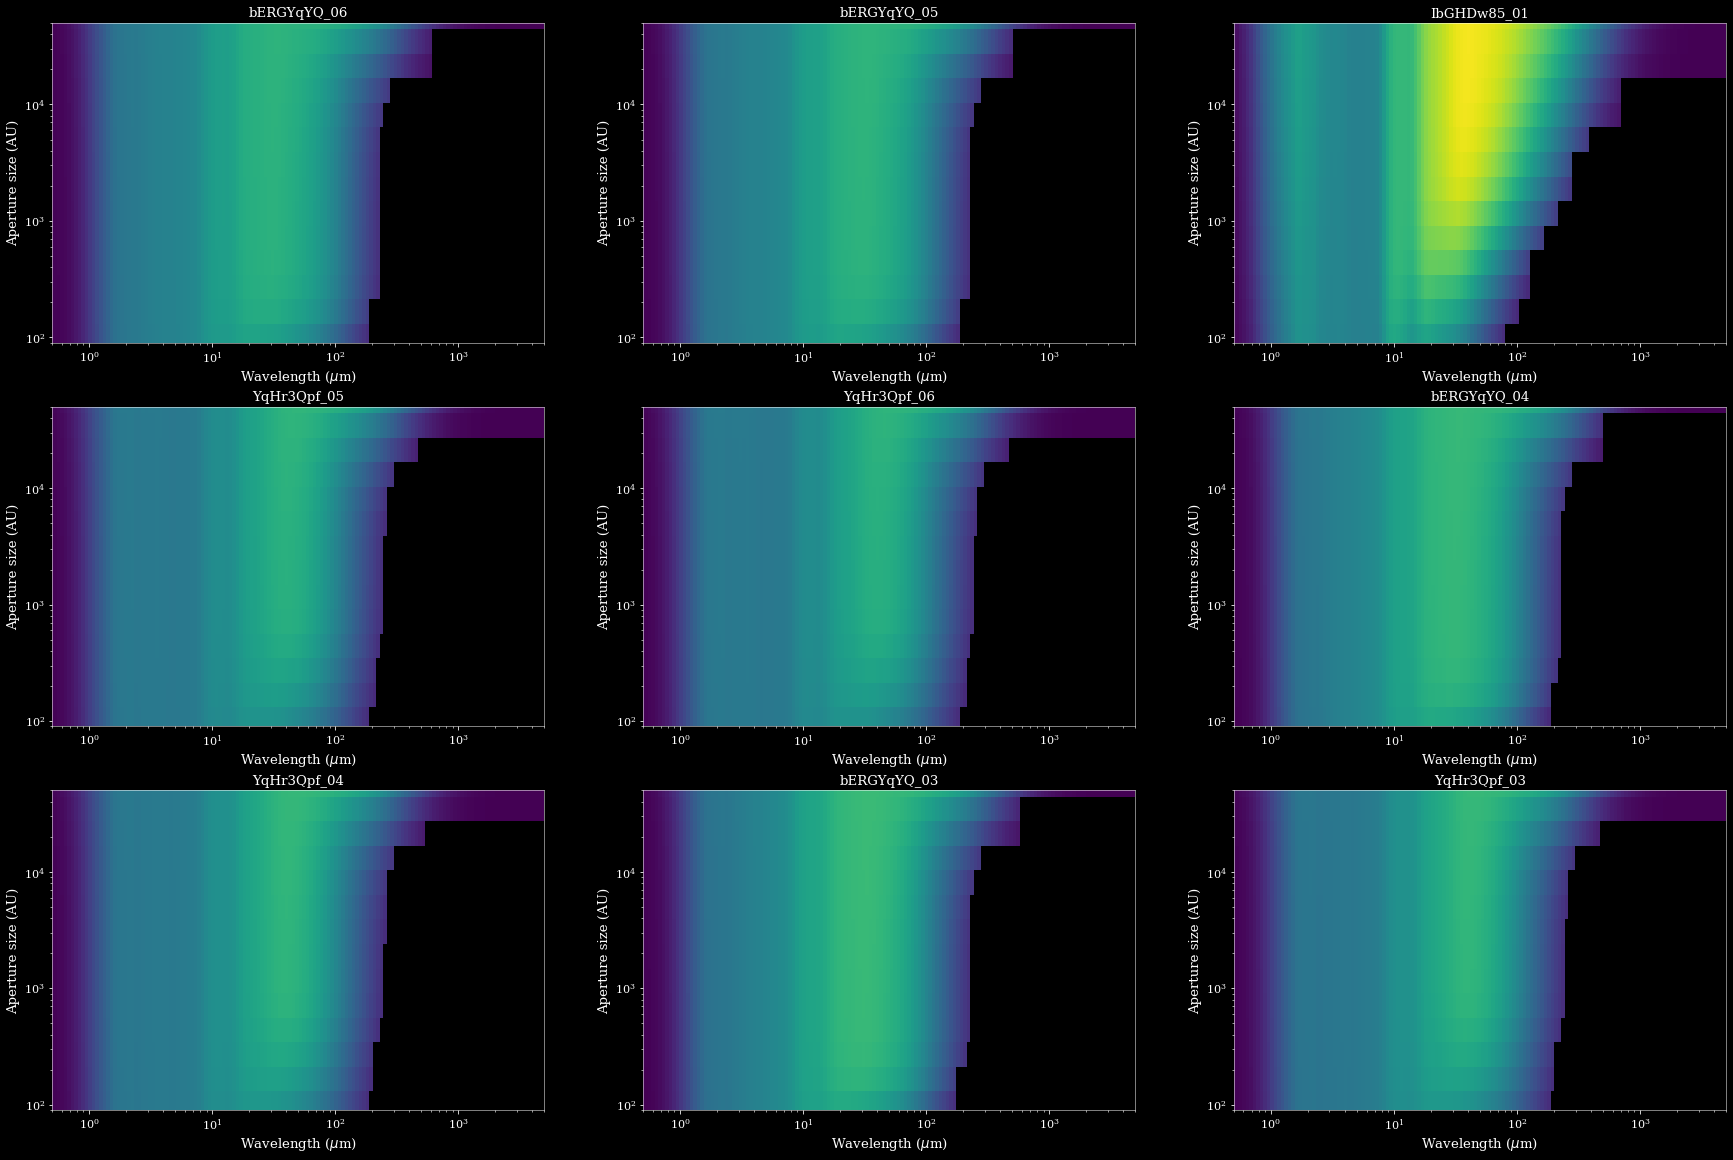

In [103]:
pl.figure(figsize=(30,20))
for ii in range(9):
    ax = pl.subplot(3,3,ii+1)

    ax.set_title(data['MODEL_NAME'][ii])
    mdl = sedcube.get_sed(data['MODEL_NAME'][ii]).flux.value
    norm = simple_norm(mdl, stretch='log')
    ax.pcolormesh(sedcube.wav.value, sedcube.apertures.value, mdl[:,:], norm=norm)
    _=ax.scatter(obs_wavs.value, obs_apertures.value, c=cb26tbl['flux'].to(u.mJy).value, norm=norm, edgecolors='w', linewidths=0.15)
    ax.loglog()
    _=ax.axis([0.5, 0.5e4, 90, 5e4])
    _=ax.set_xlabel("Wavelength ($\mu$m)")
    _=ax.set_ylabel("Aperture size (AU)")

These best-fitting plots all disagree with the measurements substantially.

The most obvious issue is that the long-wavelength data are brighter than predictions uniformly.

The agreement at short wavelengths isn't amazing either, but it's fine?  The color stretch might over-emphasize the disagreement at short wavelengths, not sure.

Figure /blue/adamginsbug/adamginsburg/SPICY_ALMAIMF//Location_figures/CB26/None.png doesn't exist


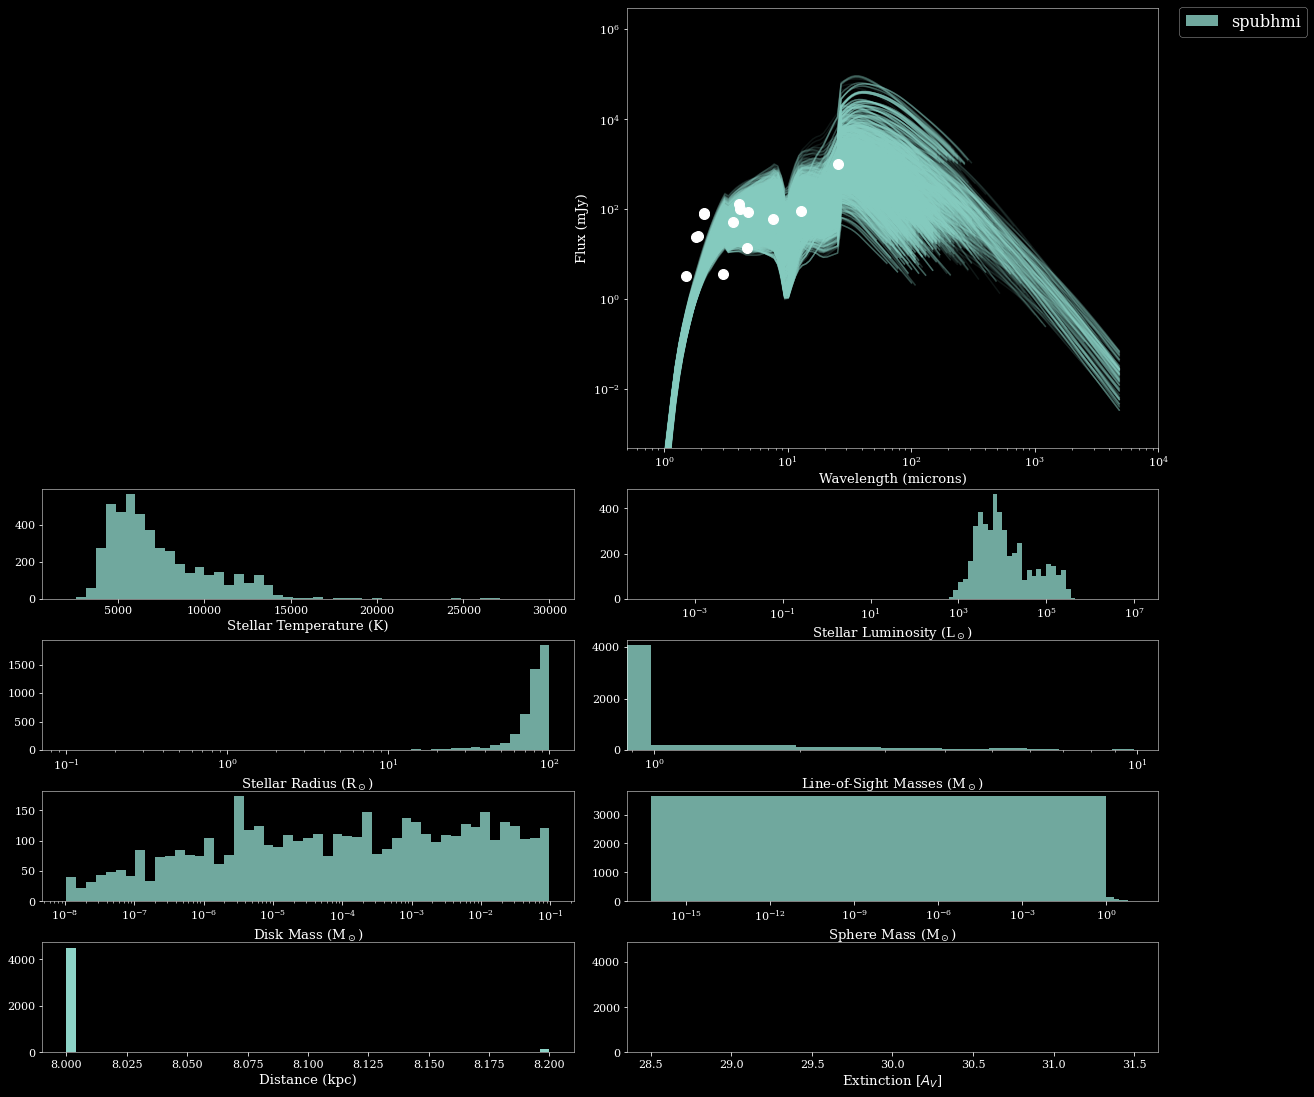

In [104]:
plot_fit(fits, ['spubhmi'], chi2limit=chi2limit,
         fieldid='CB26',
         show_all_models=True, default_aperture=(5*u.arcsec*distance).to(u.au, u.dimensionless_angles()), min_chi2=minchi2);

# What do the Robitaille model grids predict using the fitted parameters?

Using the `spubhmi` grid, we can take the parameters from Zhang et al and see what they predict.

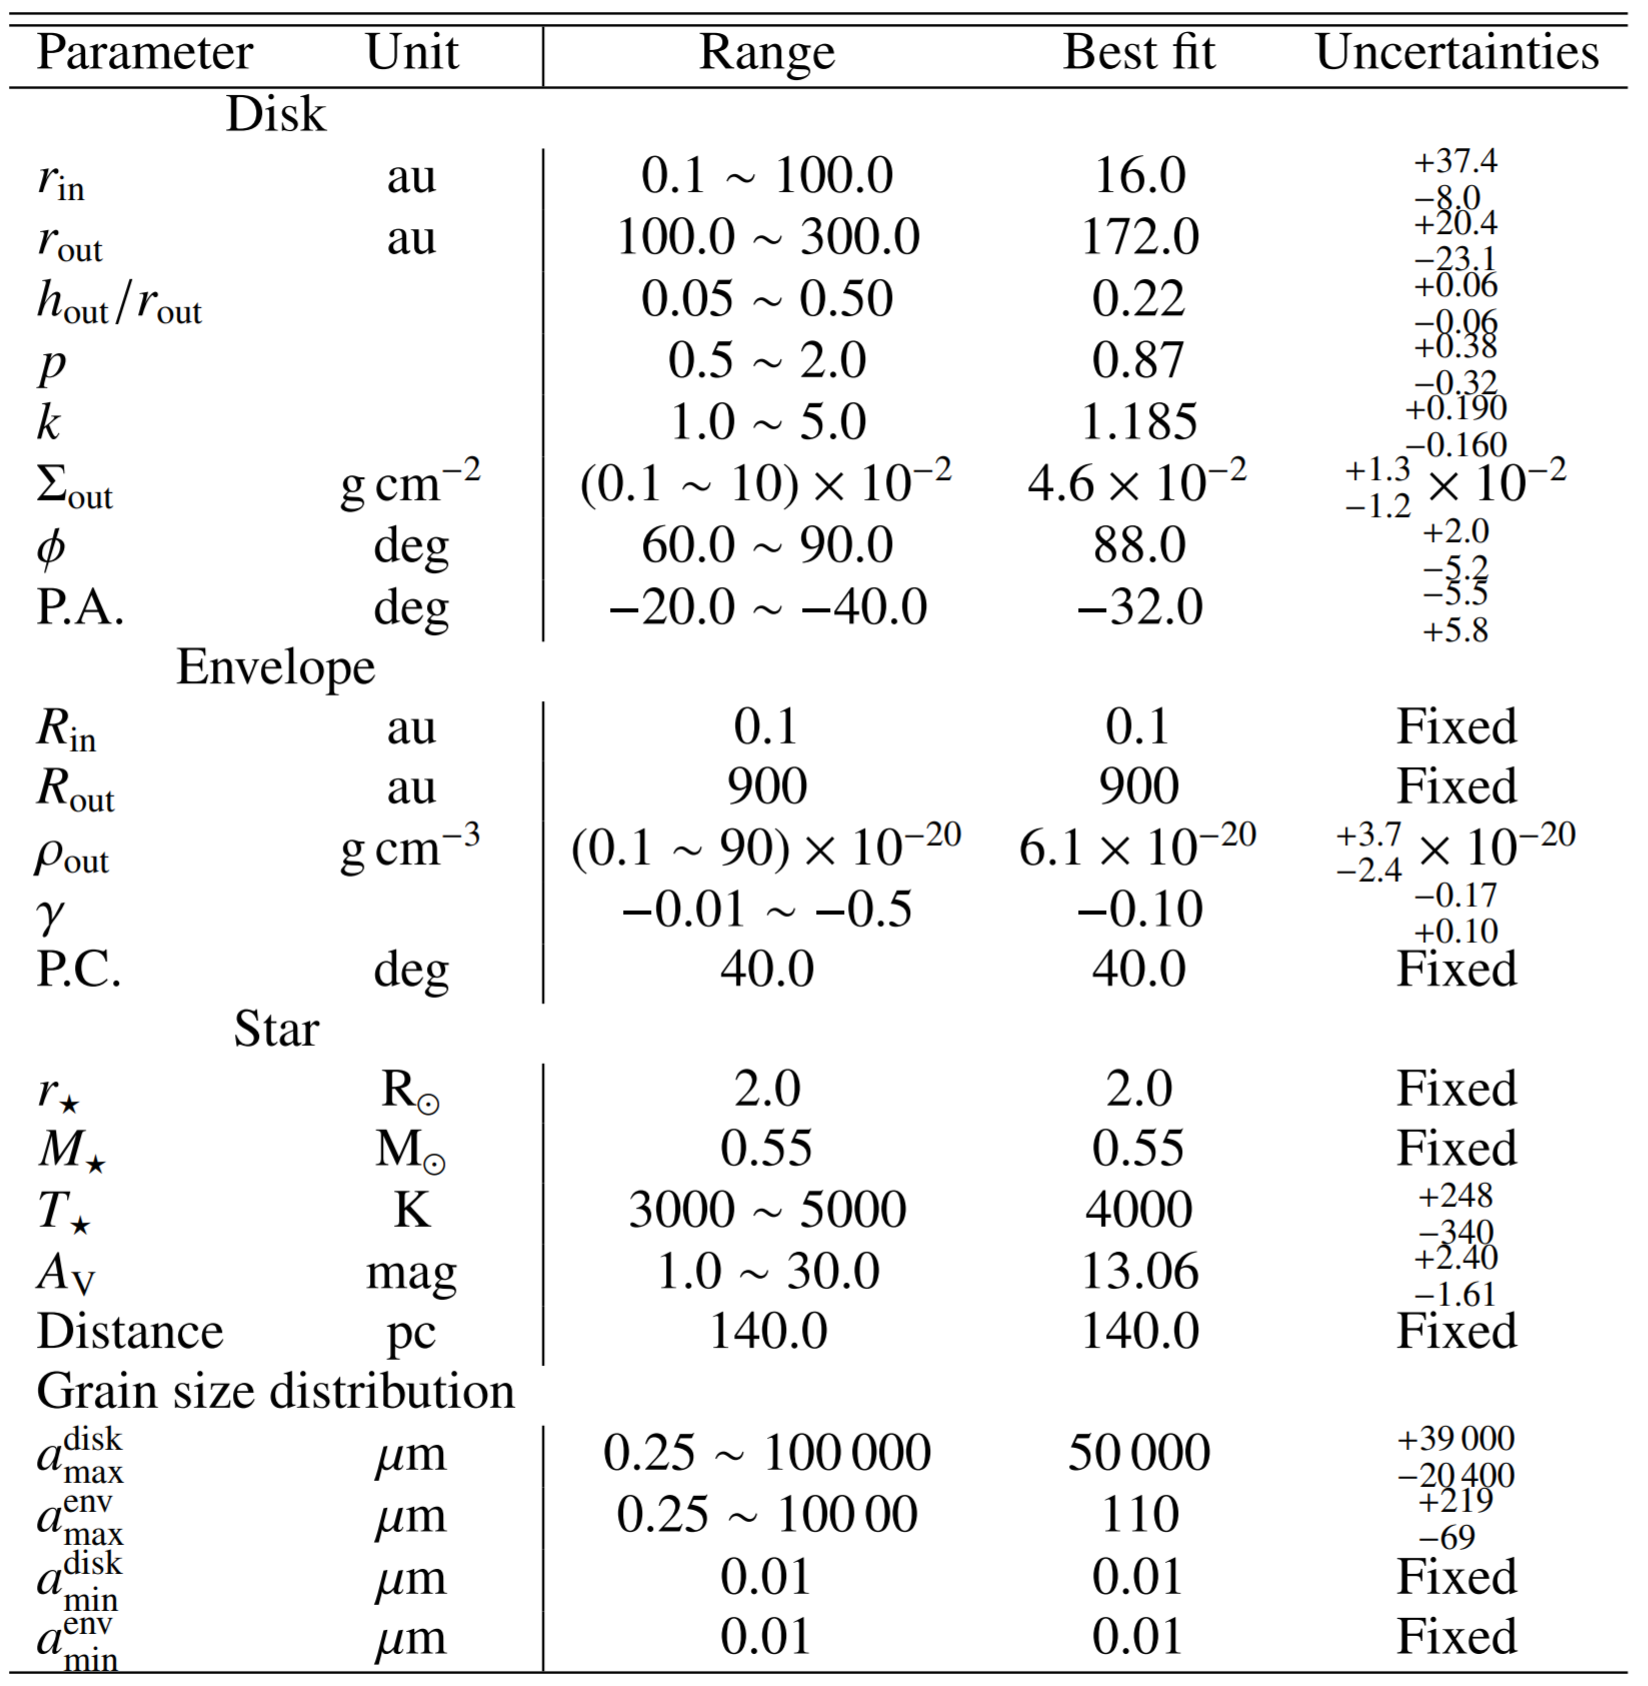

In [105]:
Image('/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/fitpars.png', width=600)

In [106]:
matches = ((pars['disk.rmax'] > 100) & (pars['disk.rmax'] < 300) &
           (pars['envelope.rho_0'] > 3.7e-20) & (pars['envelope.rho_0'] < 9.8e-20) &
           (pars['star.radius'] > 1.5) & (pars['star.radius'] < 2.5) &
           (pars['star.temperature'] < 5000) & (pars['star.temperature'] > 3000))
matches.sum()

126

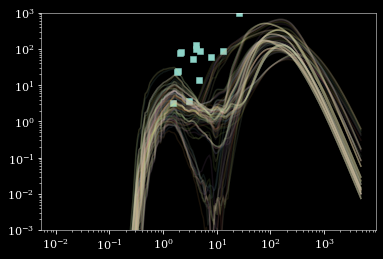

In [107]:
_=pl.loglog(sedcube.wav, sedcube.val[matches,9,:].T, alpha=0.1)
_=pl.scatter(cb26tbl['wavelength'].quantity, cb26tbl['flux'].quantity, marker='s')
_=pl.ylim(1e-3,1e3)

# More constrained fits

If we fix $A_V$, do we get closer results?

In [108]:
fits_fixedAV = {geom:
        fit_a_source(data=cb26tbl['flux'].quantity,
             error=cb26tbl['eflux'].quantity,
             valid=np.ones(len(cb26tbl)), aperture_size=cb26tbl['aperture'].quantity,
             filters=cb26tbl['wavelength'].quantity,
                   av_range=[13,14],
                   distance_range=[110,170]*u.pc,
                     geometry=geom,
                  )
        for geom in geometries}

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  s-pbhmi
   Log[d] stepping     :  0.02
   Number of distances :  11

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

Data shape=(90000, 11, 14).  use_memmap=True
   Reading fluxes at 1.5 um


Exception: Aperture(s) requested too small